### Alexnet Implementation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from alexnet import AlexNet
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset
import numpy as np

In [10]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire dataset
dataset = ImageFolder('train_imgs', transform=transform)
dataset_augmented  = ImageFolder('train_imgs', transform=transform_augmented)

In [3]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [4]:
# Define the number of folds for k-fold cross-validation
k_folds = 5

# Create KFold object to generate k-fold splits
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1)

# Create empty lists to store the accuracies for each fold
fold_accuracies = []

In [5]:
# Loop through the k-fold splits
for fold, (train_idxs, val_idxs) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    for fold_i, (train_idx_i, val_idx_i) in enumerate(kfold.split(dataset_augmented)):
        if fold == fold_i:
            train_augmented_idxs = train_idx_i
            val_augmented_idxs = val_idx_i
            continue
    
    # Create data loaders for training and validation sets
    train_dataset = torch.utils.data.Subset(dataset, train_idxs)
    train_augmented_dataset = torch.utils.data.Subset(dataset_augmented, train_augmented_idxs)
    train_dataset = ConcatDataset([train_dataset, train_augmented_dataset])

    val_dataset = torch.utils.data.Subset(dataset, val_idxs)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs and labels
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # Print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))
    # Store the loss and accuracy for this fold
    fold_accuracies.append(100 * correct / total)

# Print the mean and standard deviation of the accuracies for all folds
print(f'Mean Accuracy: {np.mean(fold_accuracies):.4f}, Std Accuracy: {np.std(fold_accuracies):.4f}')

Fold 1/5
[1,   100] loss: 4.436
[1,   200] loss: 4.162
[1,   300] loss: 3.858
[1,   400] loss: 3.624
[1,   500] loss: 3.214
[1,   600] loss: 3.028
[1,   700] loss: 2.777
[2,   100] loss: 2.468
[2,   200] loss: 2.342
[2,   300] loss: 2.387
[2,   400] loss: 2.232
[2,   500] loss: 2.064
[2,   600] loss: 2.044
[2,   700] loss: 1.925
[3,   100] loss: 1.797
[3,   200] loss: 1.775
[3,   300] loss: 1.752
[3,   400] loss: 1.723
[3,   500] loss: 1.690
[3,   600] loss: 1.656
[3,   700] loss: 1.634
[4,   100] loss: 1.512
[4,   200] loss: 1.559
[4,   300] loss: 1.488
[4,   400] loss: 1.454
[4,   500] loss: 1.464
[4,   600] loss: 1.416
[4,   700] loss: 1.419
[5,   100] loss: 1.339
[5,   200] loss: 1.270
[5,   300] loss: 1.312
[5,   400] loss: 1.295
[5,   500] loss: 1.294
[5,   600] loss: 1.295
[5,   700] loss: 1.258
[6,   100] loss: 1.182
[6,   200] loss: 1.179
[6,   300] loss: 1.189
[6,   400] loss: 1.161
[6,   500] loss: 1.171
[6,   600] loss: 1.157
[6,   700] loss: 1.149
[7,   100] loss: 1.053
[7

KeyboardInterrupt: 

### Varying Learning Rate 

In [11]:
# Split into train and test
dataset = ImageFolder('train_imgs', transform=transform)

# Define the percentage split between training and testing data
train_pct = 0.8
test_pct = 1 - train_pct

# Split the dataset into training and testing sets based on the percentage split
num_train = int(train_pct * len(dataset))
num_test = len(dataset) - num_train
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

# Create data loaders to load the data in batches during training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Learning Rate 0.1

In [24]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Save variable loss 
loss_001 = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_001.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr 0.1: %d %%' % (100 * correct / total))


#### Learning rate 0.01

In [18]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Save variable loss 
loss_01 = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_01.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr 0.01: %d %%' % (100 * correct / total))


[1,   100] loss: 4.412
[1,   200] loss: 4.200
[1,   300] loss: 3.999
Accuracy on validation set with lr 0.01: 22 %
[2,   100] loss: 3.039
[2,   200] loss: 2.733
[2,   300] loss: 2.497
Accuracy on validation set with lr 0.01: 34 %
[3,   100] loss: 2.255
[3,   200] loss: 2.091
[3,   300] loss: 2.086
Accuracy on validation set with lr 0.01: 46 %
[4,   100] loss: 1.870
[4,   200] loss: 1.821
[4,   300] loss: 1.768
Accuracy on validation set with lr 0.01: 50 %
[5,   100] loss: 1.599
[5,   200] loss: 1.627
[5,   300] loss: 1.578
Accuracy on validation set with lr 0.01: 53 %
[6,   100] loss: 1.448
[6,   200] loss: 1.427
[6,   300] loss: 1.438
Accuracy on validation set with lr 0.01: 56 %
[7,   100] loss: 1.288
[7,   200] loss: 1.301
[7,   300] loss: 1.280
Accuracy on validation set with lr 0.01: 57 %
[8,   100] loss: 1.178
[8,   200] loss: 1.169
[8,   300] loss: 1.181
Accuracy on validation set with lr 0.01: 59 %
[9,   100] loss: 1.069
[9,   200] loss: 1.077
[9,   300] loss: 1.115
Accuracy on

## Learning Rate 0.001

In [19]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Save variable loss 
loss_001 = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_001.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr 0.001: %d %%' % (100 * correct / total))


[1,   100] loss: 4.787
[1,   200] loss: 4.550
[1,   300] loss: 4.188
Accuracy on validation set with lr 0.001: 7 %
[2,   100] loss: 4.177
[2,   200] loss: 4.180
[2,   300] loss: 4.152
Accuracy on validation set with lr 0.001: 9 %
[3,   100] loss: 4.092
[3,   200] loss: 3.947
[3,   300] loss: 3.873
Accuracy on validation set with lr 0.001: 13 %
[4,   100] loss: 3.680
[4,   200] loss: 3.538
[4,   300] loss: 3.317
Accuracy on validation set with lr 0.001: 22 %
[5,   100] loss: 3.075
[5,   200] loss: 2.931
[5,   300] loss: 2.815
Accuracy on validation set with lr 0.001: 30 %
[6,   100] loss: 2.647
[6,   200] loss: 2.514
[6,   300] loss: 2.468
Accuracy on validation set with lr 0.001: 35 %
[7,   100] loss: 2.321
[7,   200] loss: 2.291
[7,   300] loss: 2.263
Accuracy on validation set with lr 0.001: 41 %
[8,   100] loss: 2.150
[8,   200] loss: 2.132
[8,   300] loss: 2.103
Accuracy on validation set with lr 0.001: 43 %
[9,   100] loss: 2.009
[9,   200] loss: 2.005
[9,   300] loss: 1.970
Accur

#### Learning rate 1e-4

In [20]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

# Save variable loss 
loss_1e4 = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_1e4.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr 1e-4: %d %%' % (100 * correct / total))


[1,   100] loss: 4.795
[1,   200] loss: 4.792
[1,   300] loss: 4.789
Accuracy on validation set with lr 1e-4: 6 %
[2,   100] loss: 4.783
[2,   200] loss: 4.778
[2,   300] loss: 4.772
Accuracy on validation set with lr 1e-4: 6 %
[3,   100] loss: 4.748
[3,   200] loss: 4.706
[3,   300] loss: 4.477
Accuracy on validation set with lr 1e-4: 6 %
[4,   100] loss: 4.209
[4,   200] loss: 4.187
[4,   300] loss: 4.192
Accuracy on validation set with lr 1e-4: 7 %
[5,   100] loss: 4.169
[5,   200] loss: 4.182
[5,   300] loss: 4.168
Accuracy on validation set with lr 1e-4: 7 %
[6,   100] loss: 4.161
[6,   200] loss: 4.166
[6,   300] loss: 4.164
Accuracy on validation set with lr 1e-4: 8 %
[7,   100] loss: 4.171
[7,   200] loss: 4.144
[7,   300] loss: 4.160
Accuracy on validation set with lr 1e-4: 8 %
[8,   100] loss: 4.153
[8,   200] loss: 4.157
[8,   300] loss: 4.160
Accuracy on validation set with lr 1e-4: 9 %
[9,   100] loss: 4.140
[9,   200] loss: 4.143
[9,   300] loss: 4.161
Accuracy on validat

### Varying Optimizer

In [21]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Save variable loss 
loss_adam = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_adam.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr 1e-4: %d %%' % (100 * correct / total))


[1,   100] loss: 70810.503
[1,   200] loss: 5.233
[1,   300] loss: 4.617
Accuracy on validation set with lr 1e-4: 6 %
[2,   100] loss: 4.846
[2,   200] loss: 32894.161
[2,   300] loss: 95.568
Accuracy on validation set with lr 1e-4: 6 %
[3,   100] loss: 105.875
[3,   200] loss: 4.562
[3,   300] loss: 4.322
Accuracy on validation set with lr 1e-4: 6 %
[4,   100] loss: 4.152
[4,   200] loss: 4.329
[4,   300] loss: 4.166
Accuracy on validation set with lr 1e-4: 6 %
[5,   100] loss: 4.162
[5,   200] loss: 35.262
[5,   300] loss: 27.647
Accuracy on validation set with lr 1e-4: 6 %
[6,   100] loss: 4.315
[6,   200] loss: 4.754
[6,   300] loss: 4.961
Accuracy on validation set with lr 1e-4: 6 %
[7,   100] loss: 4.153
[7,   200] loss: 4.497
[7,   300] loss: 4.210
Accuracy on validation set with lr 1e-4: 6 %
[8,   100] loss: 4.181
[8,   200] loss: 4.482
[8,   300] loss: 4.309
Accuracy on validation set with lr 1e-4: 6 %
[9,   100] loss: 5.846
[9,   200] loss: 4.243
[9,   300] loss: 4.630
Accura

### Add Leaky ReLU

In [22]:
from alexnet_leaky import AlexNet_leaky

# Define the AlexNet model
model = AlexNet_leaky(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Save variable loss 
loss_leaky = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_leaky.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr 0.01: %d %%' % (100 * correct / total))


[1,   100] loss: 4.375
[1,   200] loss: 4.076
[1,   300] loss: 3.510
Accuracy on validation set with lr 0.01: 27 %
[2,   100] loss: 2.808
[2,   200] loss: 2.591
[2,   300] loss: 2.321
Accuracy on validation set with lr 0.01: 38 %
[3,   100] loss: 2.080
[3,   200] loss: 1.935
[3,   300] loss: 1.871
Accuracy on validation set with lr 0.01: 49 %
[4,   100] loss: 1.709
[4,   200] loss: 1.623
[4,   300] loss: 1.622
Accuracy on validation set with lr 0.01: 53 %
[5,   100] loss: 1.473
[5,   200] loss: 1.438
[5,   300] loss: 1.448
Accuracy on validation set with lr 0.01: 56 %
[6,   100] loss: 1.273
[6,   200] loss: 1.290
[6,   300] loss: 1.283
Accuracy on validation set with lr 0.01: 58 %
[7,   100] loss: 1.127
[7,   200] loss: 1.199
[7,   300] loss: 1.194
Accuracy on validation set with lr 0.01: 59 %
[8,   100] loss: 1.112
[8,   200] loss: 1.102
[8,   300] loss: 1.085
Accuracy on validation set with lr 0.01: 60 %
[9,   100] loss: 0.965
[9,   200] loss: 0.971
[9,   300] loss: 0.997
Accuracy on

# ADAM with Lr 0.001

In [13]:
# Define the AlexNet model
model = AlexNet(num_classes=len(dataset.classes))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Save variable loss 
loss_adam = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        loss_hold = loss.item()
        loss_adam.append(loss_hold)
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set with lr .001: %d %%' % (100 * correct / total))


[1,   100] loss: 4.218
[1,   200] loss: 3.667
[1,   300] loss: 3.291
Accuracy on validation set with lr .001: 30 %
[2,   100] loss: 2.565
[2,   200] loss: 2.349
[2,   300] loss: 2.197
Accuracy on validation set with lr .001: 42 %
[3,   100] loss: 1.944
[3,   200] loss: 1.913
[3,   300] loss: 1.910
Accuracy on validation set with lr .001: 31 %
[4,   100] loss: 1.788
[4,   200] loss: 1.730
[4,   300] loss: 1.731
Accuracy on validation set with lr .001: 49 %
[5,   100] loss: 1.659
[5,   200] loss: 1.639
[5,   300] loss: 1.632
Accuracy on validation set with lr .001: 53 %
[6,   100] loss: 1.468
[6,   200] loss: 1.463
[6,   300] loss: 1.491
Accuracy on validation set with lr .001: 52 %
[7,   100] loss: 1.374
[7,   200] loss: 1.399
[7,   300] loss: 1.428
Accuracy on validation set with lr .001: 54 %
[8,   100] loss: 1.285
[8,   200] loss: 1.281
[8,   300] loss: 1.283
Accuracy on validation set with lr .001: 55 %
[9,   100] loss: 1.186
[9,   200] loss: 1.212
[9,   300] loss: 1.235
Accuracy on

## confusion mat

<AxesSubplot:>

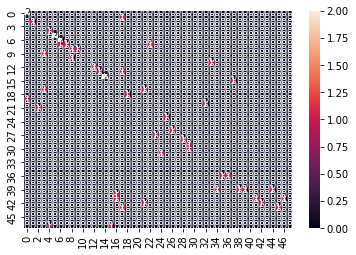

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfmat = confusion_matrix(labels, predicted)
sns.heatmap(cfmat, annot = True)

In [6]:
# Evaluate the model on the validation set
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on validation set: %d %%' % (100 * correct / total))
# Store the loss and accuracy for this fold
fold_accuracies.append(100 * correct / total)


Accuracy on validation set: 21 %


In [10]:
# Evaluate the model on the training set
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on training set: %d %%' % (100 * correct / total))

KeyboardInterrupt: 

In [6]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the model on the validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))

[1,   100] loss: 4.545
[1,   200] loss: 4.209
[1,   300] loss: 4.166
[1,   400] loss: 4.058
[1,   500] loss: 3.838
[1,   600] loss: 3.612
[1,   700] loss: 3.326
[1,   800] loss: 3.169


NameError: name 'val_loader' is not defined

In [7]:
# Evaluate the model on the validation set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy on validation set: %d %%' % (100 * correct / total))

Accuracy on validation set: 24 %
